# Complete Fetch EDA

This notebook validates the filtering properties of the two-stage complete fetch.

## Dataset
- **Source**: `data/test1/complete_*` files
- **Fetch date**: 2026-01-11
- **Date range**: 2025-12-09 to 2026-01-08 (30 days)
- **Award types**: A, B, C, D (contracts only)
- **Min amount**: >= $900,000

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries loaded")

✓ Libraries loaded


## Load Data

In [10]:
# Load complete fetch data
with open('../data/test1/complete_transactions_2026-01-11_17-08-28.json', 'r') as f:
    transactions = json.load(f)
df_tx = pd.DataFrame(transactions)

with open('../data/test1/complete_awards_2026-01-11_17-08-28.json', 'r') as f:
    awards = json.load(f)
df_aw = pd.DataFrame(awards)

with open('../data/test1/complete_stats_2026-01-11_17-08-28.json', 'r') as f:
    stats = json.load(f)

print(f"Transactions: {df_tx.shape}")
print(f"Awards: {df_aw.shape}")
print(f"\nStats:")
for key, value in stats.items():
    if key not in ['missingAwardIds']:
        print(f"  {key}: {value}")

Transactions: (735, 23)
Awards: (891, 20)

Stats:
  totalTransactions: 8805
  newTransactions: 735
  uniqueAwardIds: 721
  awardsRequested: 721
  awardsFetched: 891
  awardsMissing: -170
  transactionsWithAward: 735
  transactionsWithoutAward: 0
  joinRate: 100
  fetchTimestamp: 2026-01-11T22:08:28.281Z
  dateRange: {'start': '2025-12-09', 'end': '2026-01-08'}
  filters: {'awardTypes': ['A', 'B', 'C', 'D'], 'minAmount': 900000, 'rollingDays': 30}


In [47]:
df_tx.shape, df_tx.award_id.nunique()

((735, 23), 721)

In [91]:
# df_tx.nunique() == len(df_tx)

In [57]:
len(df_tx.drop_duplicates(subset=['transaction_id'], keep='first'))

722

In [58]:
len(df_tx)

735

In [48]:
# Deduplicate awards - keep most recent version
print(f"Before deduplication: {len(df_aw)} awards")
df_aw = df_aw.sort_values('last_modified_date', ascending=False).drop_duplicates(subset=['award_id'], keep='first')
print(f"After deduplication: {len(df_aw)} awards")
print(f"Duplicates removed: {891 - len(df_aw)}")

# Now join
joined = df_tx.merge(df_aw, on='award_id', how='left', suffixes=('_tx', '_aw'), indicator=True)
print(f"\nJoined shape: {joined.shape}")  # Should now match df_tx.shape

Before deduplication: 891 awards
After deduplication: 721 awards
Duplicates removed: 170

Joined shape: (735, 43)


In [59]:
print("=== JOIN QUALITY VALIDATION ===")
print()

# Perform join
joined = df_tx.merge(
    df_aw,
    on='award_id',
    how='left',
    suffixes=('_tx', '_aw'),
    indicator=True
)


=== JOIN QUALITY VALIDATION ===



In [86]:
joined.columns

Index(['transaction_id', 'award_id', 'generated_internal_id', 'action_date',
       'action_type', 'action_type_description', 'modification_number',
       'federal_action_obligation', 'total_dollars_obligated', 'award_type_tx',
       'award_description_tx', 'period_of_performance_start_date',
       'period_of_performance_current_end_date', 'awarding_agency_name',
       'awarding_sub_agency_name', 'funding_agency_name', 'recipient_name_tx',
       'recipient_uei_tx', 'naics_code_tx', 'product_or_service_code',
       'place_of_performance_state_tx', 'ingested_at_tx', 'source_url_tx',
       'award_type_aw', 'award_amount', 'award_date', 'start_date', 'end_date',
       'last_modified_date', 'base_obligation_date', 'awarding_agency',
       'awarding_sub_agency', 'funding_agency', 'recipient_name_aw',
       'recipient_uei_aw', 'recipient_business_categories',
       'award_description_aw', 'naics_code_aw', 'psc_code',
       'place_of_performance_state_aw', 'ingested_at_aw', 'source

In [87]:
sum(joined.recipient_name_aw != joined.recipient_name_tx)

9

In [90]:
sum(joined.award_description_aw != joined.award_description_tx)

21

In [89]:
[x for x in joined.columns if 'description' in x]

['action_type_description', 'award_description_tx', 'award_description_aw']

In [60]:
df_tx.shape

(735, 23)

In [61]:
df_aw.shape

(721, 20)

In [62]:
joined.shape

(735, 43)

In [64]:
sum(joined._merge != 'both')

0

In [65]:
[x for x in joined.columns if 'description' in x]

['action_type_description', 'award_description_tx', 'award_description_aw']

In [18]:
cols = ['award_description_tx', 'award_description_aw']

In [66]:
diff_mask = joined[cols[0]] != joined[cols[1]]
sum(diff_mask)

21

In [72]:
sum(joined.action_type_description == 'NEW')

15

In [67]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,}'.format)
pd.set_option('display.max_colwidth', 1000)

In [71]:
display_cols = ['award_description_tx', 'award_description_aw']
display_cols += ['source_url_aw']
display_cols += ['modification_number', 'action_type_description', 'federal_action_obligation']
joined[diff_mask][display_cols][:100]

,award_description_tx,award_description_aw,source_url_aw,modification_number,action_type_description,federal_action_obligation
0,EXERCISE MYUSCIS CLINS (FOR THE MONTHS OF NOV/DEC) FOR DEVSECOPS SUPPORT SERVICES. SPECIFICALLY FOR MYUSCIS SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED); EXTEND THE TASK ORDER BY SIX MONTHS AND FUND JAN/FEB. EO 4(A) EXCEPTION - SU,SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),https://www.usaspending.gov/award/291249875,P00037,NEW,"2,462,400.32"
8,DEVSECOPS SERVICES IN SUPPORT OF THE NATIONAL IMMIGRATION SYSTEM. SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED). EO 4(A) EXCEPTION - ACTION EXTENDS TASK ORDER BY 6 MONTHS AND FUNDS TWO MONTHS. SUPPORT DIRECTLY RELATED TO THE ENFORC,SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),https://www.usaspending.gov/award/291249877,P00037,NEW,"1,586,881.71"
11,"DEVSECOPS SERVICES IN SUPPORT OF THE NATIONAL IMMIGRATION SYSTEM. SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED). EO 4(A) EXCEPTION, EXTEND THE TASK ORDER FOR SIX MONTHS AND FUND JAN/FEB. THE SUPPORT DIRECTLY RELATED TO THE ENFORCEM",SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),https://www.usaspending.gov/award/291249876,P00043,NEW,"1,876,829.3"
13,REFERENCE LABORATORY TESTING,"RADIOPHARMACEUTICAL PATIENT-READY UNIT DOSES FROM CARDINAL HEALTH 414, LLC:1109813 [26-000010]",https://www.usaspending.gov/award/353439946,0,Unknown,"1,250,000.0"
20,DEVSECOPS SERVICES IN SUPPORT OF THE NATIONAL IMMIGRATION SYSTEM. EXTEND 6 MONTHS AND FUND JANUARY AND FEBRUARY SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED). EO 4(A) EXCEPTION - SUPPORT DIRECTLY RELATED TO THE ENFORCEMENT OF FEDE,SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),https://www.usaspending.gov/award/291249874,P00040,NEW,"4,828,378.82"
39,SERVICES TO SUPPORT IT LEGACY SUSTAINMENT APPLICATIONS AND DEVSECOPS FOR CORP PORTFOLIO PRODUCT LINES. MODIFICATION P00036.,SERVICES TO SUPPORT IT LEGACY SUSTAINMENT APPLICATIONS AND DEVSECOPS FOR CORP PORTFOLIO PRODUCT LINES.,https://www.usaspending.gov/award/279969331,P00038,NEW,"3,177,234.4"
74,"TASK ORDER 163, MOD 1 - EXTRAVEHICULAR ACTIVITY (EVA) AND HUMAN SURFACE MOBILITY (HSM) PROGRAM (EHP) ASSESSMENT","TASK ORDER 163, BASE - EXTRAVEHICULAR ACTIVITY (EVA) AND HUMAN SURFACE MOBILITY (HSM) PROGRAM (EHP) ASSESSMENT",https://www.usaspending.gov/award/291811528,P00001,NEW,"1,359,544.0"
121,PROTECTIVE SECURITY OFFICER (PSO) SERVICES FOR FEDERAL TRIANGLE COMPLEX IN WASHINGTON DC.,PROTECTIVE SECURITY OFFICER (PSO) SERVICES IN WASHINGTON DC,https://www.usaspending.gov/award/291241440,P00034,NEW,"3,951,361.84"
200,"SPRINGER NATURE CUSTOMER SERVICE CENTER, LLC:1288642 [26-000311]",12 MONTHS OF A PROGRAM MANAGER POSITION SUPPORTING THE DIVISION OF MEDICAL ARTS.,https://www.usaspending.gov/award/354249035,0,Unknown,"3,402,721.27"
201,"NATIONAL INSTITUTE OF CHILD HEALTH AND HUMAN DEVELOPMENT (NICHD), ADMINISTRATIVE AND RESEARCH SUPPORT LARC-2025-NICHD-0004",12 MONTHS OF A PROGRAM MANAGER POSITION SUPPORTING THE DIVISION OF MEDICAL ARTS.,https://www.usaspending.gov/award/354249035,0,Unknown,"5,329,203.79"


In [83]:
joined

,transaction_id,award_id,generated_internal_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type_tx,award_description_tx,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name_tx,recipient_uei_tx,naics_code_tx,product_or_service_code,place_of_performance_state_tx,ingested_at_tx,source_url_tx,award_type_aw,award_amount,award_date,start_date,end_date,last_modified_date,base_obligation_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name_aw,recipient_uei_aw,recipient_business_categories,award_description_aw,naics_code_aw,psc_code,place_of_performance_state_aw,ingested_at_aw,source_url_aw,_merge
0,291249875,70SBUR21F00000122,CONT_AWD_70SBUR21F00000122_7003_HHSN316201200125W_7529,2026-01-08,A,NEW,P00037,"2,462,400.32","2,462,400.32",DELIVERY ORDER,EXERCISE MYUSCIS CLINS (FOR THE MONTHS OF NOV/DEC) FOR DEVSECOPS SUPPORT SERVICES. SPECIFICALLY FOR MYUSCIS SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED); EXTEND THE TASK ORDER BY SIX MONTHS AND FUND JAN/FEB. EO 4(A) EXCEPTION - SU,2021-07-19,None,Department of Homeland Security,U.S. Citizenship and Immigration Services,Department of Homeland Security,"CUSTOMER VALUE PARTNERS, LLC",L6R3M86AFBB5,541512,DA01,VA,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/70SBUR21F00000122,Unknown,"83,783,457.33",,2021-07-19,2026-02-28,2026-01-08,2021-06-23,Department of Homeland Security,U.S. Citizenship and Immigration Services,Department of Homeland Security,"CUSTOMER VALUE PARTNERS, LLC",L6R3M86AFBB5,[],SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),541512,None,VA,2026-01-11T22:08:28.269Z,https://www.usaspending.gov/award/291249875,both
1,354234088,70Z08526F38503B00,CONT_AWD_70Z08526F38503B00_7008_70Z08524D34001B00_7008,2026-01-08,,Unknown,0,"1,285,764.0","1,285,764.0",DELIVERY ORDER,"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-4, R-10 AND R-11",2026-01-08,None,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,ROLLS-ROYCE SOLUTIONS AMERICA INC,HYGLK2BNFKB3,333618,J020,SC,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/70Z08526F38503B00,Unknown,"1,285,764.0",,2026-01-08,2027-04-06,2026-01-08,2026-01-08,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,ROLLS-ROYCE SOLUTIONS AMERICA INC,HYGLK2BNFKB3,[],"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-4, R-10 AND R-11",333618,None,SC,2026-01-11T22:08:28.270Z,https://www.usaspending.gov/award/354234088,both
2,354228889,36C77626C0021,CONT_AWD_36C77626C0021_3600_-NONE-_-NONE-,2026-01-08,,Unknown,0,"15,659,015.0","15,659,015.0",DEFINITIVE CONTRACT,636-502 CONSTRUCT STERILE PROCESSING SERVICE - OMAHA VAMC,2026-01-08,None,Department of Veterans Affairs,Department of Veterans Affairs,Department of Veterans Affairs,MCL-MRK VII LLC,GP66DEVNP2A1,236220,Y1DA,NE,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/36C77626C0021,Unknown,"15,659,015.0",,2026-01-08,2027-07-07,2026-01-08,2026-01-08,Department of Veterans Affairs,Department of Veterans Affairs,Department of Veterans Affairs,MCL-MRK VII LLC,GP66DEVNP2A1,[],636-502 CONSTRUCT STERILE PROCESSING SERVICE - OMAHA VAMC,236220,None,NE,2026-01-11T22:08:28.269Z,https://www.usaspending.gov/award/354228889,both
3,354234087,70Z08526F38502B00,CONT_AWD_70Z08526F38502B00_7008_70Z08524D34001B00_7008,2026-01-08,,Unknown,0,"1,189,252.0","1,189,252.0",DELIVERY ORDER,"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-1, R-2 AND R-5.",2026-01-08,None,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,ROLLS-ROYCE SOLUTIONS AMERICA INC,HYGLK2BNFKB3,333618,J020,SC,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/70Z08526F38502B00,Unknown,"1,189,252.0",,2026-01-08,2026-05-25,2026-01-08,2026-01-08,Department of Homeland Security,U.S. Coast Guar

In [79]:
output_cols = [
    'action_date',
    'awarding_agency_name',
    'awarding_sub_agency_name',
    'award_description_tx',
    'award_description_aw',  # only if diff from _tx
    'recipient_name_aw',
    'naics_code_aw',
    'source_url_aw',
    # 'generated_internal_id',  # for https://www.usaspending.gov/award/<generated_internal_id>
]

In [81]:
output_df = joined[output_cols]

In [82]:
output_df.head(2)

,action_date,awarding_agency_name,awarding_sub_agency_name,award_description_tx,award_description_aw,recipient_name_aw,naics_code_aw,source_url_aw
0,2026-01-08,Department of Homeland Security,U.S. Citizenship and Immigration Services,EXERCISE MYUSCIS CLINS (FOR THE MONTHS OF NOV/DEC) FOR DEVSECOPS SUPPORT SERVICES. SPECIFICALLY FOR MYUSCIS SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED); EXTEND THE TASK ORDER BY SIX MONTHS AND FUND JAN/FEB. EO 4(A) EXCEPTION - SU,SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),"CUSTOMER VALUE PARTNERS, LLC",541512,https://www.usaspending.gov/award/291249875
1,2026-01-08,Department of Homeland Security,U.S. Coast Guard,"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-4, R-10 AND R-11","REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-4, R-10 AND R-11",ROLLS-ROYCE SOLUTIONS AMERICA INC,333618,https://www.usaspending.gov/award/354234088


In [84]:
output_df.to_csv('../data/output_csvs/output-1.csv', index=False)

In [73]:
joined

,transaction_id,award_id,generated_internal_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type_tx,award_description_tx,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name_tx,recipient_uei_tx,naics_code_tx,product_or_service_code,place_of_performance_state_tx,ingested_at_tx,source_url_tx,award_type_aw,award_amount,award_date,start_date,end_date,last_modified_date,base_obligation_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name_aw,recipient_uei_aw,recipient_business_categories,award_description_aw,naics_code_aw,psc_code,place_of_performance_state_aw,ingested_at_aw,source_url_aw,_merge
0,291249875,70SBUR21F00000122,CONT_AWD_70SBUR21F00000122_7003_HHSN316201200125W_7529,2026-01-08,A,NEW,P00037,"2,462,400.32","2,462,400.32",DELIVERY ORDER,EXERCISE MYUSCIS CLINS (FOR THE MONTHS OF NOV/DEC) FOR DEVSECOPS SUPPORT SERVICES. SPECIFICALLY FOR MYUSCIS SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED); EXTEND THE TASK ORDER BY SIX MONTHS AND FUND JAN/FEB. EO 4(A) EXCEPTION - SU,2021-07-19,None,Department of Homeland Security,U.S. Citizenship and Immigration Services,Department of Homeland Security,"CUSTOMER VALUE PARTNERS, LLC",L6R3M86AFBB5,541512,DA01,VA,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/70SBUR21F00000122,Unknown,"83,783,457.33",,2021-07-19,2026-02-28,2026-01-08,2021-06-23,Department of Homeland Security,U.S. Citizenship and Immigration Services,Department of Homeland Security,"CUSTOMER VALUE PARTNERS, LLC",L6R3M86AFBB5,[],SERVICES FOR PRODUCT ENGINEERING AND ENTERPRISE DELIVERY (SPEED),541512,None,VA,2026-01-11T22:08:28.269Z,https://www.usaspending.gov/award/291249875,both
1,354234088,70Z08526F38503B00,CONT_AWD_70Z08526F38503B00_7008_70Z08524D34001B00_7008,2026-01-08,,Unknown,0,"1,285,764.0","1,285,764.0",DELIVERY ORDER,"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-4, R-10 AND R-11",2026-01-08,None,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,ROLLS-ROYCE SOLUTIONS AMERICA INC,HYGLK2BNFKB3,333618,J020,SC,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/70Z08526F38503B00,Unknown,"1,285,764.0",,2026-01-08,2027-04-06,2026-01-08,2026-01-08,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,ROLLS-ROYCE SOLUTIONS AMERICA INC,HYGLK2BNFKB3,[],"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-4, R-10 AND R-11",333618,None,SC,2026-01-11T22:08:28.270Z,https://www.usaspending.gov/award/354234088,both
2,354228889,36C77626C0021,CONT_AWD_36C77626C0021_3600_-NONE-_-NONE-,2026-01-08,,Unknown,0,"15,659,015.0","15,659,015.0",DEFINITIVE CONTRACT,636-502 CONSTRUCT STERILE PROCESSING SERVICE - OMAHA VAMC,2026-01-08,None,Department of Veterans Affairs,Department of Veterans Affairs,Department of Veterans Affairs,MCL-MRK VII LLC,GP66DEVNP2A1,236220,Y1DA,NE,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/36C77626C0021,Unknown,"15,659,015.0",,2026-01-08,2027-07-07,2026-01-08,2026-01-08,Department of Veterans Affairs,Department of Veterans Affairs,Department of Veterans Affairs,MCL-MRK VII LLC,GP66DEVNP2A1,[],636-502 CONSTRUCT STERILE PROCESSING SERVICE - OMAHA VAMC,236220,None,NE,2026-01-11T22:08:28.269Z,https://www.usaspending.gov/award/354228889,both
3,354234087,70Z08526F38502B00,CONT_AWD_70Z08526F38502B00_7008_70Z08524D34001B00_7008,2026-01-08,,Unknown,0,"1,189,252.0","1,189,252.0",DELIVERY ORDER,"REPAIR SERVICE FOR VARIOUS WMSL ENGINE PARTS FOR CLINS: R-1, R-2 AND R-5.",2026-01-08,None,Department of Homeland Security,U.S. Coast Guard,Department of Homeland Security,ROLLS-ROYCE SOLUTIONS AMERICA INC,HYGLK2BNFKB3,333618,J020,SC,2026-01-11T22:08:22.336Z,https://www.usaspending.gov/award/70Z08526F38502B00,Unknown,"1,189,252.0",,2026-01-08,2026-05-25,2026-01-08,2026-01-08,Department of Homeland Security,U.S. Coast Guar

In [37]:
joined.iloc[11:12]

,transaction_id,award_id,generated_internal_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type_tx,award_description_tx,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name_tx,recipient_uei_tx,naics_code_tx,product_or_service_code,place_of_performance_state_tx,ingested_at_tx,source_url_tx,award_type_aw,award_amount,award_date,start_date,end_date,last_modified_date,base_obligation_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name_aw,recipient_uei_aw,recipient_business_categories,award_description_aw,naics_code_aw,psc_code,place_of_performance_state_aw,ingested_at_aw,source_url_aw,_merge
11,354243278,15BGCS26F00000001,CONT_AWD_15BGCS26F00000001_1540_15BFA025A00000039_1540,2026-01-08,,Unknown,0,"1,273,836.0","1,273,836.0",BPA CALL,CENTRAL OFFICE MATTRESS ORDER FOR ALL REGIONS - MULTIPLE INSTITUTIONS,2026-01-08,None,Department of Justice,Federal Prison System / Bureau of Prisons,Department of Justice,"FEDERAL PRISON INDUSTRIES, INC",KHFLCLB4BW91,315990,7210,KY,2026-01-11T22:08:22.337Z,https://www.usaspending.gov/award/15BGCS26F00000001,Unknown,"683,666.58",,2025-12-08,2026-01-05,2025-12-08,2025-12-08,Department of Justice,Federal Prison System / Bureau of Prisons,Department of Justice,ALLIED TUBE & CONDUIT CORPORATION,J3WSJTMBRWA1,[],"THE PROVISION FOR 30"" COILED BARBED TAPE (RAZOR WIRE) BOTH NON-REINFORCED AND REINFORCED FOR FCI LORETTO.",334290,None,IL,2026-01-11T22:08:28.270Z,https://www.usaspending.gov/award/353366345,both


In [33]:
joined.iloc[335:336]

,transaction_id,award_id,generated_internal_id,action_date,action_type,action_type_description,modification_number,federal_action_obligation,total_dollars_obligated,award_type_tx,award_description_tx,period_of_performance_start_date,period_of_performance_current_end_date,awarding_agency_name,awarding_sub_agency_name,funding_agency_name,recipient_name_tx,recipient_uei_tx,naics_code_tx,product_or_service_code,place_of_performance_state_tx,ingested_at_tx,source_url_tx,award_type_aw,award_amount,award_date,start_date,end_date,last_modified_date,base_obligation_date,awarding_agency,awarding_sub_agency,funding_agency,recipient_name_aw,recipient_uei_aw,recipient_business_categories,award_description_aw,naics_code_aw,psc_code,place_of_performance_state_aw,ingested_at_aw,source_url_aw,_merge
335,291527860,75FCMC19F0001,CONT_AWD_75FCMC19F0001_7530_HHSM500201600012I_7530,2025-12-24,A,NEW,P00017,"11,902,890.0","11,902,890.0",DELIVERY ORDER,"HEALTHCARE FRAUD PREVENTION AND PARTNERSHIP(HPFF)TRUSTED THIRD PARTY (TTP) MODIFICATION TO EXTENT AND FUND THE PERIOD USING 42 CFR 400 AND 421, ""MEDICARE INTEGRITY PROGRAM"" AND 42 CFR PART 455 FOR THE ""MEDICAID INTEGRITY PROGRAM",2019-09-28,None,Department of Health and Human Services,Centers for Medicare and Medicaid Services,Department of Health and Human Services,"GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.",SMNWM6HN79X5,541512,D302,VA,2026-01-11T22:08:22.350Z,https://www.usaspending.gov/award/75FCMC19F0001,Unknown,"44,313,930.74",,2019-06-01,2024-05-31,2025-09-09,2019-05-31,Department of Health and Human Services,Centers for Medicare and Medicaid Services,Department of Health and Human Services,"GENERAL DYNAMICS INFORMATION TECHNOLOGY, INC.",SMNWM6HN79X5,[],DRUG DATA PROCESSING SYSTEM (DDPS)&PAYMENT RECONCILIATION SYSTEM (PRS),541512,None,VA,2026-01-11T22:08:28.271Z,https://www.usaspending.gov/award/291527858,both


## Validation 6: Data Consistency

Check consistency between transaction and award data

In [8]:
print("=== DATA CONSISTENCY VALIDATION ===")
print()

# Check recipient name matching
if 'recipient_name_tx' in matched.columns and 'recipient_name_aw' in matched.columns:
    recipient_match = matched['recipient_name_tx'] == matched['recipient_name_aw']
    print(f"Recipient names match: {recipient_match.sum()} / {len(matched)} ({recipient_match.sum()/len(matched)*100:.1f}%)")
    
    if not recipient_match.all():
        print(f"\nMismatched recipients: {(~recipient_match).sum()}")
        mismatched = matched[~recipient_match][['award_id', 'recipient_name_tx', 'recipient_name_aw']].head(10)
        print(mismatched)

# Check agency matching
if 'awarding_agency_name_tx' in matched.columns and 'awarding_agency_aw' in matched.columns:
    agency_match = matched['awarding_agency_name_tx'] == matched['awarding_agency_aw']
    print(f"\nAwarding agencies match: {agency_match.sum()} / {len(matched)} ({agency_match.sum()/len(matched)*100:.1f}%)")

# Check award amounts
if 'federal_action_obligation' in matched.columns and 'award_amount' in matched.columns:
    print(f"\nAmount comparison:")
    print(f"  Transaction amount (avg): ${matched['federal_action_obligation'].mean():,.2f}")
    print(f"  Award amount (avg): ${matched['award_amount'].mean():,.2f}")
    print(f"  Note: Award amounts are typically >= transaction amounts (award is total, transaction is single action)")
    
    # Check where transaction > award (unusual)
    tx_exceeds_award = matched['federal_action_obligation'] > matched['award_amount']
    if tx_exceeds_award.any():
        print(f"\n⚠️  {tx_exceeds_award.sum()} transactions where transaction amount > award amount")
        exceeds = matched[tx_exceeds_award][['award_id', 'federal_action_obligation', 'award_amount', 'recipient_name_tx']].head(10)
        print(exceeds)

print("\n✅ Data consistency checks complete")

=== DATA CONSISTENCY VALIDATION ===

Recipient names match: 737 / 926 (79.6%)

Mismatched recipients: 189
             award_id                  recipient_name_tx  \
11  15BGCS26F00000001     FEDERAL PRISON INDUSTRIES, INC   
15     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
16     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
17     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
18     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
19     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
20     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
21     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
22     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   
23     75N90026F00001  MAYO COLLABORATIVE SERVICES, INC.   

                     recipient_name_aw  
11   ALLIED TUBE & CONDUIT CORPORATION  
15       AMERICAS STAFFING PARTNER INC  
16            CARDINAL HEALTH 414, LLC  
17       BECTON, DICKINSON AND COMPANY  
18      PENOBSCOT HEALTH SER

## Summary Visualizations

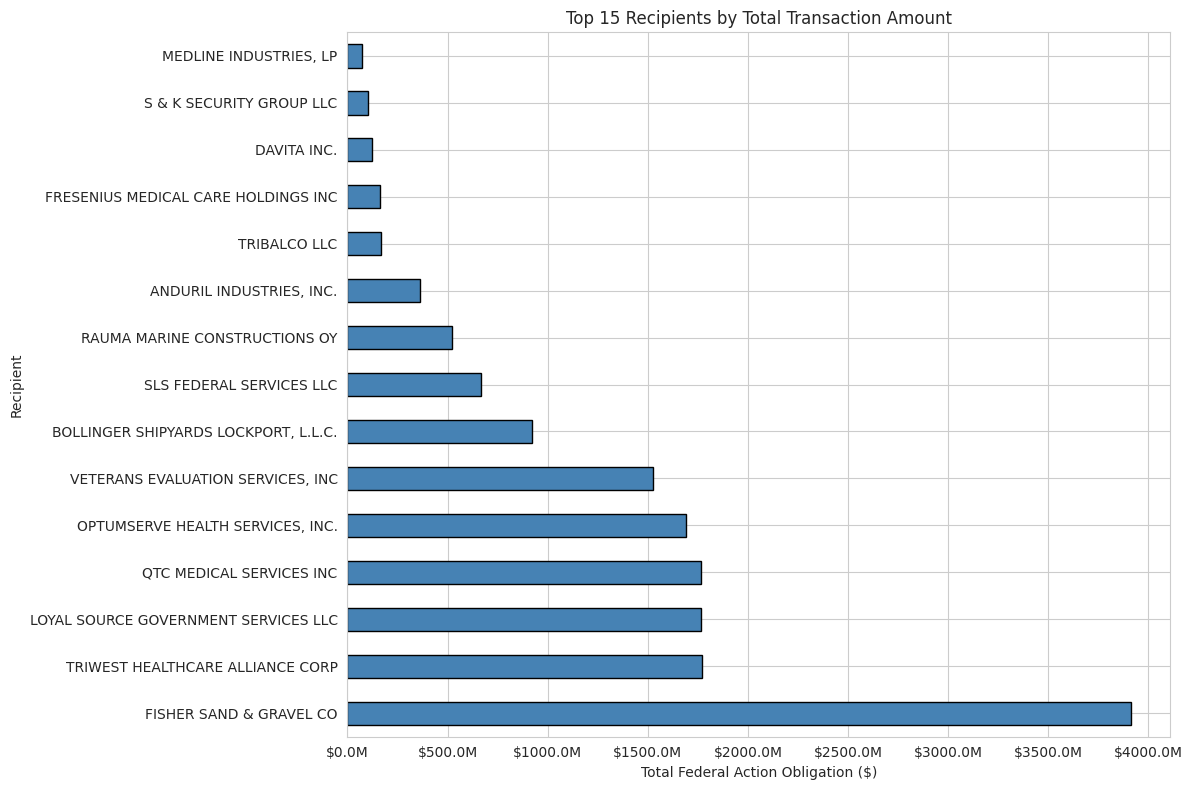

In [9]:
# Top recipients by total obligation
top_recipients = df_tx.groupby('recipient_name')['federal_action_obligation'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
top_recipients.plot(kind='barh', color='steelblue', edgecolor='black')
plt.xlabel('Total Federal Action Obligation ($)')
plt.ylabel('Recipient')
plt.title('Top 15 Recipients by Total Transaction Amount')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.tight_layout()
plt.show()

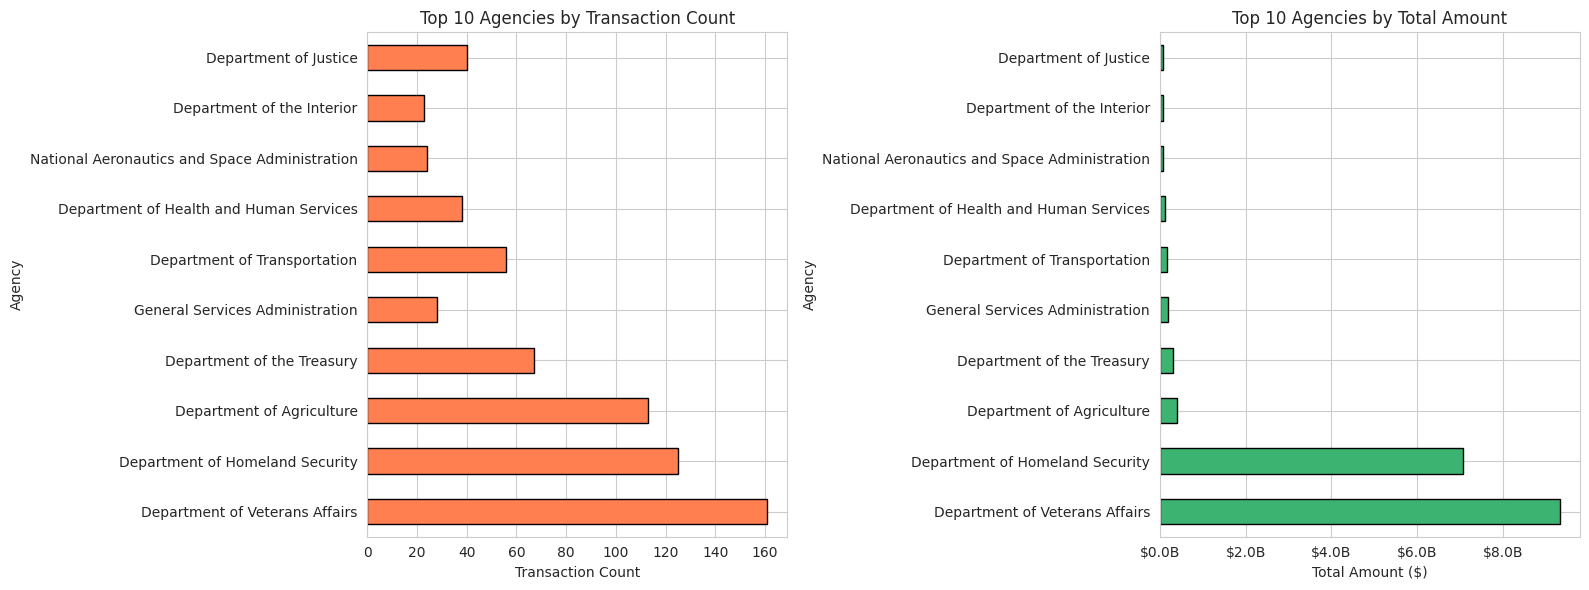

In [10]:
# Transactions by awarding agency
agency_stats = df_tx.groupby('awarding_agency_name').agg({
    'transaction_id': 'count',
    'federal_action_obligation': 'sum'
}).sort_values('federal_action_obligation', ascending=False).head(10)
agency_stats.columns = ['Count', 'Total Amount']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count
agency_stats['Count'].plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_xlabel('Transaction Count')
axes[0].set_ylabel('Agency')
axes[0].set_title('Top 10 Agencies by Transaction Count')

# Amount
agency_stats['Total Amount'].plot(kind='barh', ax=axes[1], color='mediumseagreen', edgecolor='black')
axes[1].set_xlabel('Total Amount ($)')
axes[1].set_ylabel('Agency')
axes[1].set_title('Top 10 Agencies by Total Amount')
axes[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e9:.1f}B'))

plt.tight_layout()
plt.show()

## Final Summary Report

In [11]:
print("="*80)
print("COMPLETE FETCH VALIDATION REPORT")
print("="*80)
print()
print(f"Dataset: {stats['fetchTimestamp']}")
print(f"Date Range: {stats['dateRange']['start']} to {stats['dateRange']['end']} ({stats['filters']['rollingDays']} days)")
print(f"Min Amount: ${stats['filters']['minAmount']:,}")
print(f"Award Types: {', '.join(stats['filters']['awardTypes'])}")
print()

print("FILTER VALIDATION RESULTS:")
print(f"  1. New transactions filter: {'✅ PASS' if is_new.all() else '❌ FAIL'}")
print(f"  2. Minimum amount filter: {'✅ PASS' if meets_min.all() else '❌ FAIL'}")
print(f"  3. Date range filter: {'✅ PASS' if in_range.all() else '❌ FAIL'}")
print(f"  4. Award type filter: {'✅ PASS' if is_contract.all() else '⚠️  CHECK'}")
print(f"  5. Join quality: ✅ {stats['joinRate']}% join rate")
print()

print("DATASET STATISTICS:")
print(f"  Total transactions: {stats['totalTransactions']:,}")
print(f"  New transactions (filtered): {stats['newTransactions']:,}")
print(f"  Unique awards: {stats['uniqueAwardIds']:,}")
print(f"  Awards fetched: {stats['awardsFetched']:,}")
print(f"  Missing awards: {stats['awardsMissing']:,}")
print()

print("SUMMARY:")
if is_new.all() and meets_min.all() and in_range.all() and stats['joinRate'] == 100:
    print("  ✅ ALL VALIDATION CHECKS PASSED")
    print("  The dataset correctly reflects the filtering criteria.")
    print("  100% join rate achieved - all transactions have matching awards!")
else:
    print("  ⚠️  SOME VALIDATION CHECKS FAILED")
    print("  Review the detailed results above.")

print()
print("="*80)

COMPLETE FETCH VALIDATION REPORT

Dataset: 2026-01-11T22:08:28.281Z
Date Range: 2025-12-09 to 2026-01-08 (30 days)
Min Amount: $900,000
Award Types: A, B, C, D

FILTER VALIDATION RESULTS:
  1. New transactions filter: ✅ PASS
  2. Minimum amount filter: ✅ PASS
  3. Date range filter: ✅ PASS
  4. Award type filter: ✅ PASS
  5. Join quality: ✅ 100% join rate

DATASET STATISTICS:
  Total transactions: 8,805
  New transactions (filtered): 735
  Unique awards: 721
  Awards fetched: 891
  Missing awards: -170

SUMMARY:
  ✅ ALL VALIDATION CHECKS PASSED
  The dataset correctly reflects the filtering criteria.
  100% join rate achieved - all transactions have matching awards!

